In [2]:
!pip install pyspark

In [3]:
from pyspark.sql import SparkSession
session=SparkSession.builder.appName("project").getOrCreate()

In [4]:
data=session.read.csv("credit_risk_dataset.csv", header=True, inferSchema=True)

In [5]:
from pyspark.sql.functions import col

In [7]:
print("Number of observations:",data.count())

Number of observations: 999
Information of columns:
 ['person_id', 'person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'cb_person_default_on_file', 'cb_person_cred_hist_length', 'credit_score', 'loan_to_income_ratio', 'number_of_open_accounts', 'past_delinquency_count']
+-------+------------------+-----------------+-----------------+---------------------+-----------------+-----------------+----------+------------------+------------------+-------------------+-------------------------+--------------------------+------------------+--------------------+-----------------------+----------------------+
|summary|         person_id|       person_age|    person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|         loan_amnt|     loan_int_rate|        loan_status|cb_person_default_on_file|cb_person_cred_hist_length|      credit_score|loan_to_income_ratio|number_of_open

In [10]:
print("Information of columns:\n",data.columns)

Information of columns:
 ['person_id', 'person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'cb_person_default_on_file', 'cb_person_cred_hist_length', 'credit_score', 'loan_to_income_ratio', 'number_of_open_accounts', 'past_delinquency_count']


In [9]:
print("Description of columns:\n",data.describe().show())

+-------+------------------+-----------------+-----------------+---------------------+-----------------+-----------------+----------+------------------+------------------+-------------------+-------------------------+--------------------------+------------------+--------------------+-----------------------+----------------------+
|summary|         person_id|       person_age|    person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|         loan_amnt|     loan_int_rate|        loan_status|cb_person_default_on_file|cb_person_cred_hist_length|      credit_score|loan_to_income_ratio|number_of_open_accounts|past_delinquency_count|
+-------+------------------+-----------------+-----------------+---------------------+-----------------+-----------------+----------+------------------+------------------+-------------------+-------------------------+--------------------------+------------------+--------------------+-----------------------+----------------------+
|  c

In [8]:
print("First few records:\n",data.show())

+---------+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------------+--------------------------+------------+--------------------+-----------------------+----------------------+
|person_id|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_grade|loan_amnt|loan_int_rate|loan_status|cb_person_default_on_file|cb_person_cred_hist_length|credit_score|loan_to_income_ratio|number_of_open_accounts|past_delinquency_count|
+---------+----------+-------------+---------------------+-----------------+-----------------+----------+---------+-------------+-----------+-------------------------+--------------------------+------------+--------------------+-----------------------+----------------------+
|        1|        27|        59000|                 RENT|                7|         PERSONAL|         D|    35000|        16.02|          1|                        Y|     

## Finding the number of missing values for every field/variable

In [12]:
from pyspark.sql.functions import col
columns_with_missing = 0
for column in data.columns:
    # Check if the column has any null values
    null_count_value = data.filter(col(column).isNull()).count()

    print(f"Column '{column}' has {null_count_value} missing values.")
    if null_count_value > 0:
        columns_with_missing += 1

Column 'person_id' has 0 missing values.
Column 'person_age' has 0 missing values.
Column 'person_income' has 9 missing values.
Column 'person_home_ownership' has 8 missing values.
Column 'person_emp_length' has 38 missing values.
Column 'loan_intent' has 6 missing values.
Column 'loan_grade' has 10 missing values.
Column 'loan_amnt' has 10 missing values.
Column 'loan_int_rate' has 115 missing values.
Column 'loan_status' has 4 missing values.
Column 'cb_person_default_on_file' has 8 missing values.
Column 'cb_person_cred_hist_length' has 0 missing values.
Column 'credit_score' has 13 missing values.
Column 'loan_to_income_ratio' has 12 missing values.
Column 'number_of_open_accounts' has 7 missing values.
Column 'past_delinquency_count' has 0 missing values.


In [13]:
print("Columns with missing values: ", columns_with_missing)

Columns with missing values:  12


## Imputing

### Imputing Missing Loan-to-Income Ratio - Making sure the loan-to-income ratio is not missing or blank for any customer where loan and income values are not missing

In [16]:
from pyspark.sql.functions import col, lit, when

def update_loan_to_income_ratio(data):
    # Update the 'loan_to_income' column based on conditions
    data = data.withColumn('loan_to_income_ratio',when(col('loan_amnt').isNotNull() & col('person_income').isNotNull(), col('loan_amnt') / col('person_income')).otherwise(lit(0)))
    return data

### Imputing Loan Interest Rate
Based on the dataset, Interest Rate is classified into categories (Ex: A,B,C..)
Each category has an identifiable range of interest rates. The following function first groups the values by Loan Grade and calculates the mean for each grade. That mean value is then imputed for every missing interest rate per grade.

In [17]:
from pyspark.sql.functions import col, mean, when

def impute_interest_rate(data):
    mean_int_rate = data.groupBy('loan_grade').agg(mean('loan_int_rate').alias('mean_int_rate'))
    imputed_data = data.join(mean_int_rate, on='loan_grade', how='left')
    imputed_data = imputed_data.withColumn('loan_int_rate',when(col('loan_int_rate').isNotNull(), col('loan_int_rate')).otherwise(col('mean_int_rate')))
    imputed_data = imputed_data.drop('mean_int_rate')
    return imputed_data


In [19]:
# Calling the functions
data = impute_interest_rate(data)
data = update_loan_to_income_ratio(data)

## Filtering

In [20]:
data=data.na.drop(subset=["person_id","loan_amnt","person_age","person_income","person_home_ownership","person_emp_length","loan_intent","loan_grade","loan_status","cb_person_default_on_file","cb_person_cred_hist_length","credit_score","number_of_open_accounts","past_delinquency_count"])
print("Number of observations after removing missing values for Loan Amount column:",data.count())
data.show()

Number of observations after removing missing values for Loan Amount column: 925
+----------+---------+----------+-------------+---------------------+-----------------+-----------------+---------+-------------+-----------+-------------------------+--------------------------+------------+--------------------+-----------------------+----------------------+
|loan_grade|person_id|person_age|person_income|person_home_ownership|person_emp_length|      loan_intent|loan_amnt|loan_int_rate|loan_status|cb_person_default_on_file|cb_person_cred_hist_length|credit_score|loan_to_income_ratio|number_of_open_accounts|past_delinquency_count|
+----------+---------+----------+-------------+---------------------+-----------------+-----------------+---------+-------------+-----------+-------------------------+--------------------------+------------+--------------------+-----------------------+----------------------+
|         D|        1|        27|        59000|                 RENT|                7|    

### Final check for missing values in the observation

In [27]:
columns_with_missing = 0
for column in data.columns:
    null_count_value = data.filter(col(column).isNull()).count()
    print(f"Column '{column}' has {null_count_value} missing values.")
    if null_count_value > 0:
        columns_with_missing += 1

Column 'loan_grade' has 0 missing values.
Column 'person_id' has 0 missing values.
Column 'person_age' has 0 missing values.
Column 'person_income' has 0 missing values.
Column 'person_home_ownership' has 0 missing values.
Column 'person_emp_length' has 0 missing values.
Column 'loan_intent' has 0 missing values.
Column 'loan_amnt' has 0 missing values.
Column 'loan_int_rate' has 0 missing values.
Column 'loan_status' has 0 missing values.
Column 'cb_person_default_on_file' has 0 missing values.
Column 'cb_person_cred_hist_length' has 0 missing values.
Column 'credit_score' has 0 missing values.
Column 'loan_to_income_ratio' has 0 missing values.
Column 'number_of_open_accounts' has 0 missing values.
Column 'past_delinquency_count' has 0 missing values.


## After the dataset has been cleaned up, let's now perform an EDA

### Exploratory Data Analysis

In [22]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
print(data.describe())

DataFrame[summary: string, loan_grade: string, person_id: string, person_age: string, person_income: string, person_home_ownership: string, person_emp_length: string, loan_intent: string, loan_amnt: string, loan_int_rate: string, loan_status: string, cb_person_default_on_file: string, cb_person_cred_hist_length: string, credit_score: string, loan_to_income_ratio: string, number_of_open_accounts: string, past_delinquency_count: string]


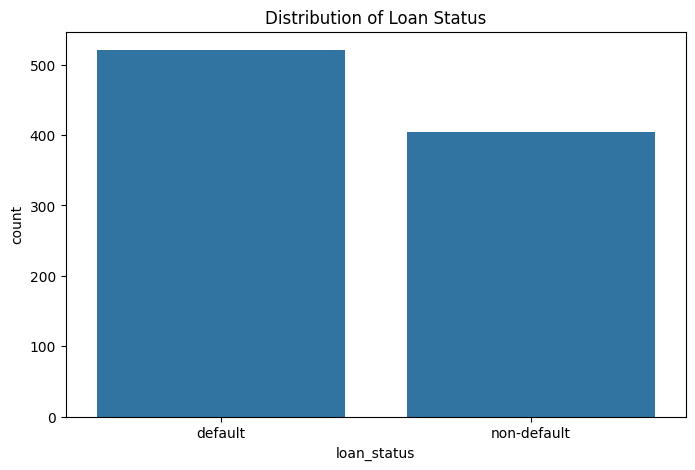

In [26]:
# Bringing in Pandas library to create dataframe
data_pandas = data.toPandas()
data_pandas['loan_status'] = data_pandas['loan_status'].replace({0: 'non-default', 1: 'default'})
plt.figure(figsize=(8,5))
sns.countplot(x='loan_status', data=data_pandas)
plt.title('Distribution of Loan Status')
plt.show()

#### Upon running analysis, the visualization indicates that the number of customers who defaulted are more than the ones who did not default on the granted loan

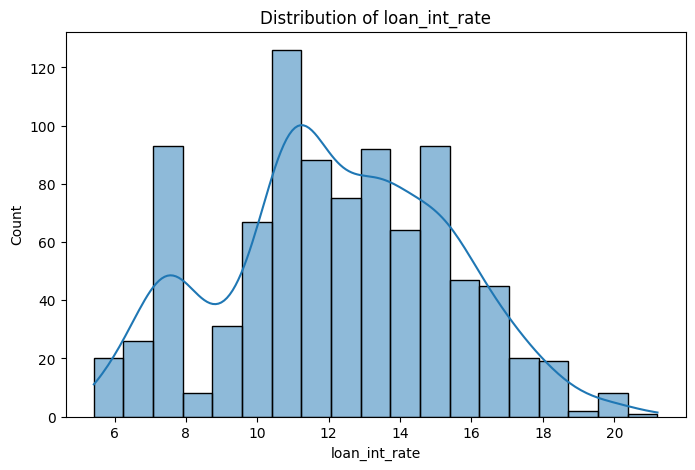

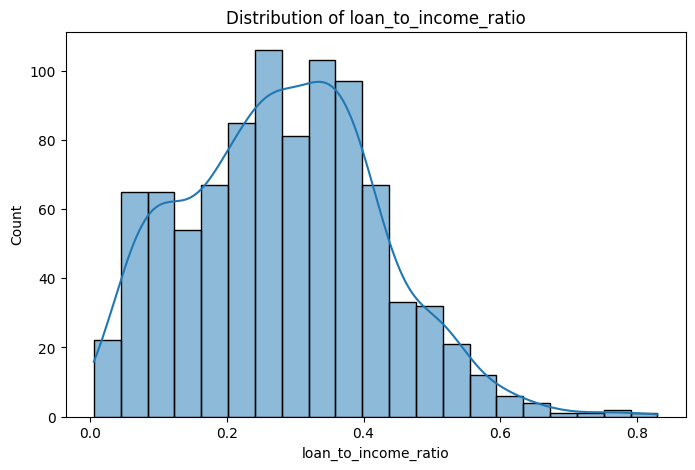

In [27]:
num_columns = data_pandas.select_dtypes(include=['float64', 'int64']).columns
for column in num_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data_pandas[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

#### In the first visual, we notice that maximum number of customers have been charged a loan interest rate between 10-12 %, which means considering industry standards

#### In the second visual, we notice that maximum number of customers that have a loan to income ratio between 0.2 - 0.4. Hence, we can conclude that the customers have been offered less than 50% as a loan amount of their yearly income

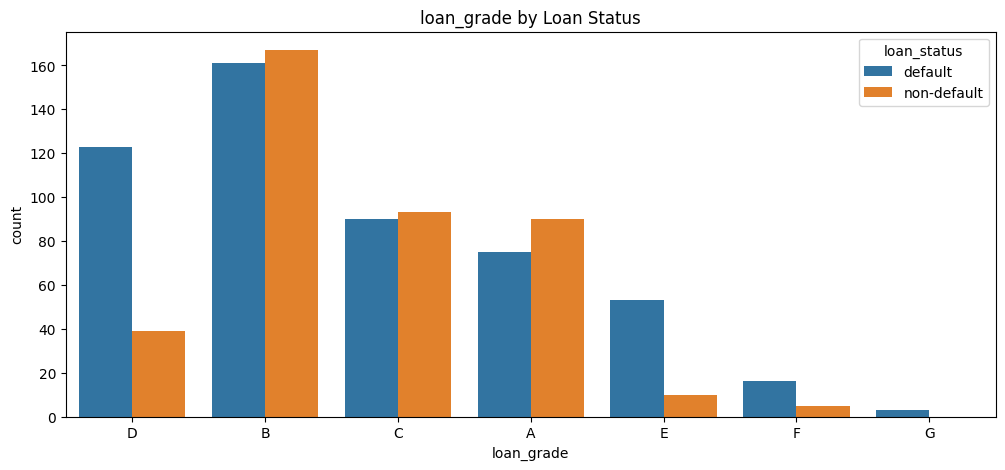

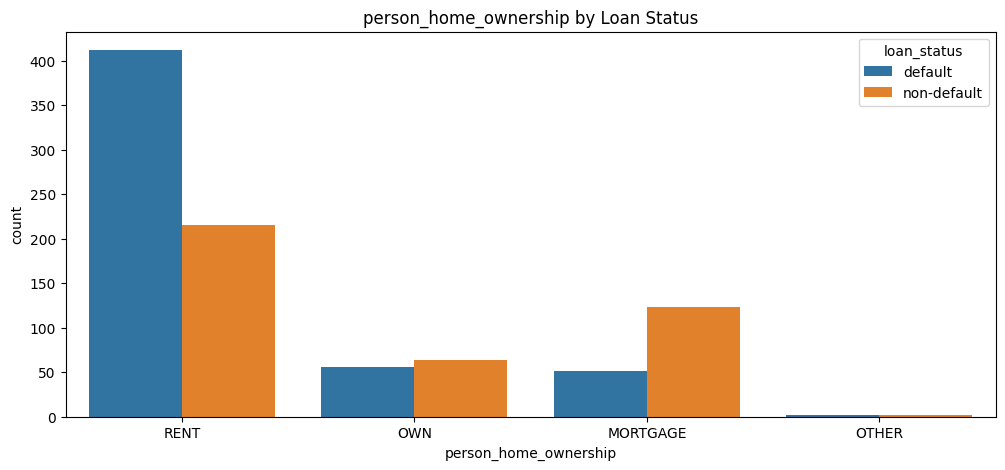

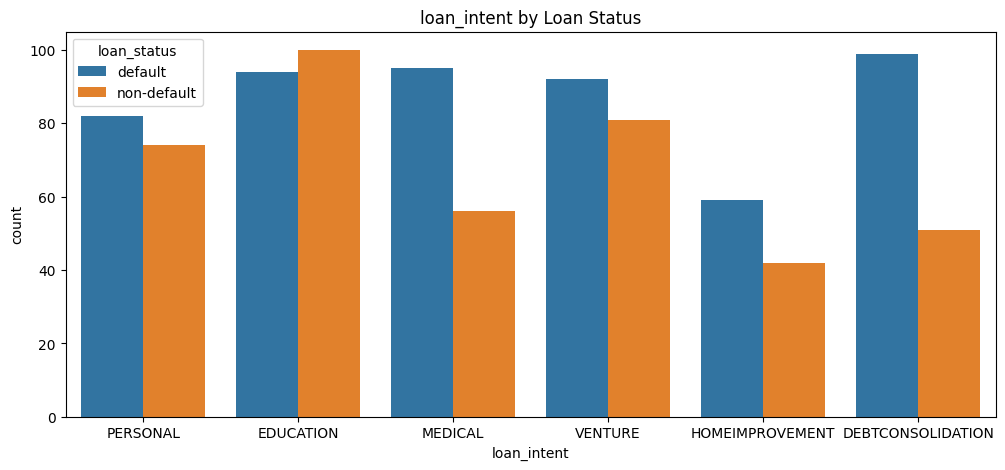

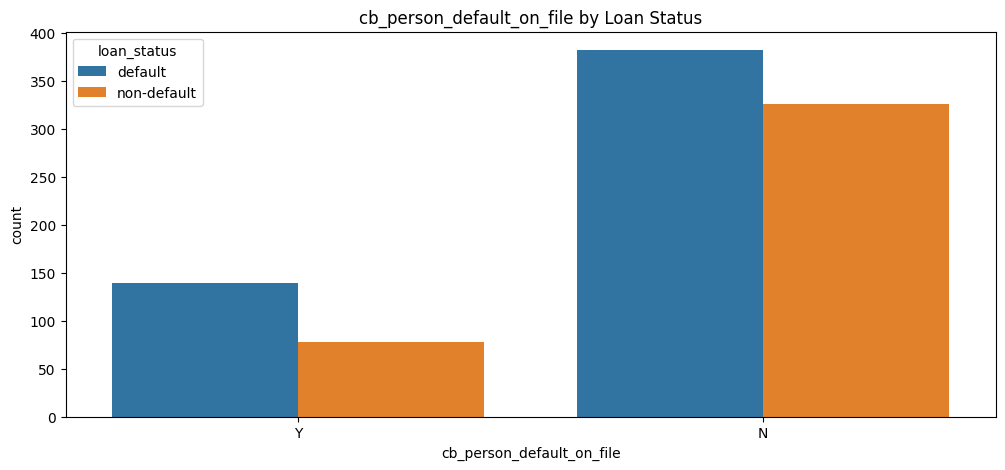

In [34]:
catego_columns = [col for col in data_pandas.select_dtypes(include=['object']).columns if col != 'loan_status']

for column in catego_columns:
    plt.figure(figsize=(12, 5))
    sns.countplot(x=column, hue='loan_status', data=data_pandas)
    plt.title(f'{column} by Loan Status')
    plt.show()

## Business case I
#### To find the number of defaulted customers with a credit score and average personal income
#### The data has been grouped based on the loan grade and loan intent

In [35]:
data.createOrReplaceTempView("credit_risk_table")
query = """SELECT loan_grade, loan_intent, COUNT(*) as DefaulterCount
           FROM credit_risk_table
           WHERE credit_score >= 680 AND cb_person_default_on_file = 'Y' AND person_income > 77800
           GROUP BY loan_grade, loan_intent
           ORDER BY loan_grade"""
result = session.sql(query)
result.show()

+----------+-----------------+--------------+
|loan_grade|      loan_intent|DefaulterCount|
+----------+-----------------+--------------+
|         C|          VENTURE|             1|
|         C|         PERSONAL|             1|
|         C|DEBTCONSOLIDATION|             2|
|         C|          MEDICAL|             1|
|         C|        EDUCATION|             1|
|         C|  HOMEIMPROVEMENT|             1|
|         D|          VENTURE|             1|
|         D|         PERSONAL|             2|
|         D|DEBTCONSOLIDATION|             2|
|         D|        EDUCATION|             2|
|         D|          MEDICAL|             1|
|         E|  HOMEIMPROVEMENT|             2|
|         E|        EDUCATION|             1|
|         F|          VENTURE|             1|
+----------+-----------------+--------------+



The above analysis tells us about the number of customers who have a credit score above 680 which is a good credit score and a personal income of above 77800 which is an average income but has still defaulted.
Based on the analysis, we can say
*   VENTURE - 3
*   PERSONAL - 3
*   DEBTCONSOLIDATION - 4
*   MEDICAL - 2
*   EDUCATION - 4
*   HOMEIMPROVEMENT - 3


From the above analysis, we can infer that customers default most when they take loans for debt consolidation and education. Due to COVID taking a toll on all industries, it has become difficult individuals to repay the debt they perviously had and as a result they have multiple loans to repay the previous debt.
Due to the job market condition, the customers who may have taken an education are defaulting, as they are finding it difficult to find a job and repay the loan.

### Business Case II

#### Number of defaulters between the age 31-40, who have defaulted in the past more than 3 times, having a credit history length more than 10.
#### The data has been grouped based on age and past credit history length



In [44]:
query2 = """SELECT person_age, person_home_ownership, COUNT(*) as DefaulterCount
            FROM credit_risk_table
            WHERE cb_person_cred_hist_length > 10 AND (person_age > 30 AND person_age < 40) AND past_delinquency_count > 3
            GROUP BY person_age, person_home_ownership
            ORDER BY person_age"""
result2 = session.sql(query2)
result2.show()

+----------+---------------------+--------------+
|person_age|person_home_ownership|DefaulterCount|
+----------+---------------------+--------------+
|        31|                 RENT|             5|
|        32|                 RENT|             2|
|        33|                 RENT|             2|
|        34|                 RENT|             1|
|        34|             MORTGAGE|             3|
|        35|                 RENT|             2|
|        36|             MORTGAGE|             1|
|        36|                  OWN|             2|
|        37|                 RENT|             1|
|        37|             MORTGAGE|             2|
|        39|             MORTGAGE|             1|
|        39|                 RENT|             2|
+----------+---------------------+--------------+



##### Based on the above observation, there are considerable number of middle-aged customers with a long credit history have defaulted previously.

##### By grouping customers based on both Age and Home Ownership the financial institution gains insights into specific customer financial particulars more prone to risk. Identifying higher risks within certain age or Home Ownership details highlights potential challenges that should be tackled.
##### From the above analysis we can infer that - there doesn't appear to be a clear pattern regarding age and defaulting, especially when home ownership is also taken into consideration. There might be a relationship between home ownership status and defaulting.

## GraphFrame

In [9]:
#Installing the necessary libraries
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://bitbucket.org/habedi/datasets/raw/b6769c4664e7ff68b001e2f43bc517888cbe3642/spark/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!rm -rf spark-3.0.2-bin-hadoop2.7.tgz*
!pip -q install findspark pyspark graphframes

In [10]:
#Initializing the environment
import os
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell"

In [11]:
from graphframes import *
from pyspark import *
from pyspark.sql import *
from graphframes import GraphFrame
spark = SparkSession.builder.appName('myframe').getOrCreate()

In [12]:
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
session=SparkSession.builder.appName("project").getOrCreate()
data=session.read.csv("credit_risk_dataset.csv", header=True, inferSchema=True)

In [13]:
vertices = data.select(col("person_id").alias("id"), "person_age", "loan_amnt", "person_income")
edges = spark.read.option('header', 'true').csv('edges.csv')
vertices.show()
edges.show()

+---+----------+---------+-------------+
| id|person_age|loan_amnt|person_income|
+---+----------+---------+-------------+
|  1|        27|    35000|        59000|
|  2|        40|     1000|         9600|
|  3|        49|     5500|         9600|
|  4|        35|    35000|        65500|
|  5|        31|    35000|        54400|
|  6|        28|     2500|         9900|
|  7|        49|    35000|        77100|
|  8|        41|    35000|        78956|
|  9|        27|    35000|        83000|
| 10|        46|     1600|        10000|
| 11|        39|    35000|        85000|
| 12|        43|     4500|        10000|
| 13|        31|    35000|        95000|
| 14|        31|    35000|       108160|
| 15|        44|    35000|       115000|
| 16|        41|    30000|       500000|
| 17|        24|    35000|       120000|
| 18|        28|    35000|        92111|
| 19|        44|    35000|       113000|
| 20|        23|     1750|        10800|
+---+----------+---------+-------------+
only showing top

In [14]:
gf = GraphFrame(vertices,edges)
inDegrees = gf.inDegrees
inDegrees.show()
pageRank = gf.pageRank(resetProbability=0.15, maxIter=10)
pageRank.vertices.select("id", "pagerank").show()

+---+--------+
| id|inDegree|
+---+--------+
|124|       1|
|428|       1|
| 11|       1|
| 42|       3|
|348|       1|
|584|       2|
|742|       1|
|933|       2|
|107|       3|
|658|       2|
|185|       1|
|840|       1|
|858|       3|
|627|       1|
| 58|       2|
|242|       1|
|566|       1|
|783|       3|
|589|       3|
|407|       1|
+---+--------+
only showing top 20 rows

+---+------------------+
| id|          pagerank|
+---+------------------+
|451|0.7790486093059387|
|454|0.7790486093059387|
|147|0.7790486093059387|
|155|0.7790486093059387|
|772|0.7790486093059387|
|752| 2.666293865349575|
|586|0.7790486093059387|
|667|0.7790486093059387|
|428|1.4412399272159864|
|464|0.7790486093059387|
| 11| 20.22825869068271|
| 14|0.7790486093059387|
|912|0.7790486093059387|
|302|0.7790486093059387|
|140|0.7790486093059387|
|204|0.7790486093059387|
|195|0.7790486093059387|
|215|0.7790486093059387|
|  1|0.7790486093059387|
|226|0.7790486093059387|
+---+------------------+
only showing t

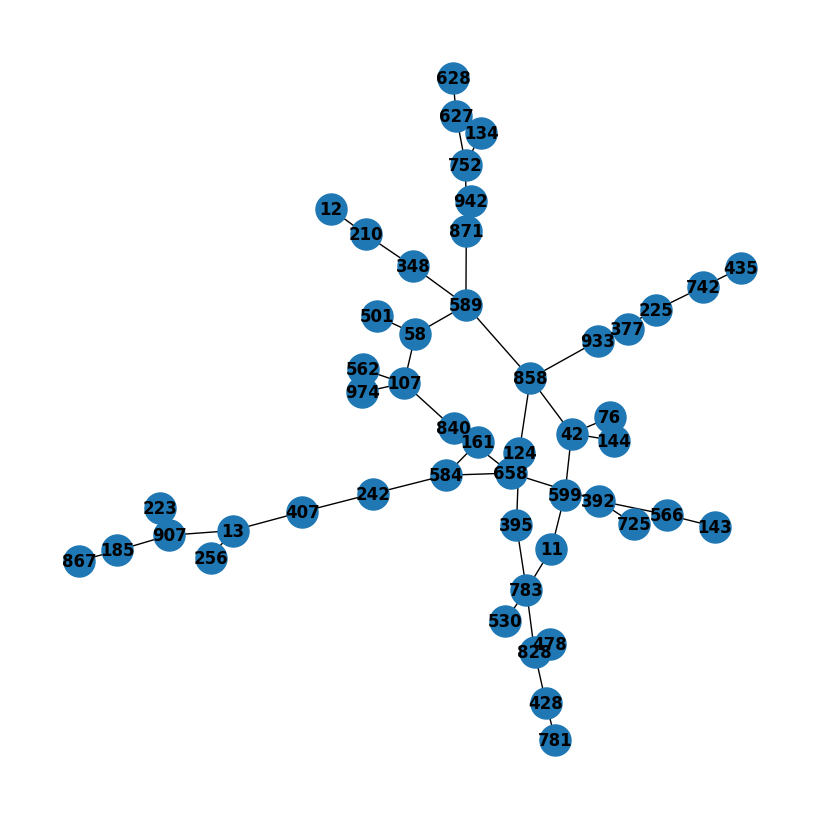

In [15]:
import networkx as net
import matplotlib.pyplot as plot
def undirected_graph(edges_l):
    plot.figure(figsize=(8,8))
    graphplot=net.Graph()
    for row in edges_l.select("src", "dst").take(1000):
        graphplot.add_edge(row["src"], row["dst"])
    net.draw(graphplot, with_labels=True, font_weight="bold", node_size=500)
undirected_graph(gf.edges)

#### In the context of credit risk analysis, the links between various entities in this network represent customers. Given its numerous connections, the core node may be a significant participant with a high degree of social interaction, indicating its significance and possible impact on risk. Individual risk entities are represented by single nodes, whereas clusters may indicate groups with similar financial activity.

## Feature Engineering

 A feature converter that transforms category data into numerical indices.

In [49]:
from pyspark.ml.feature import StringIndexer
str_obj=StringIndexer(inputCols=["person_home_ownership","loan_intent","cb_person_default_on_file","loan_grade"],outputCols=["newperson_home_ownership","newloan_intent","newcb_person_default_on_file","newloan_grade"])

Converting the indexed categorical data into a format that is appropriate for machine learning algorithms.

In [50]:
from pyspark.ml.feature import OneHotEncoder
onehot_obj=OneHotEncoder(inputCols=["newperson_home_ownership","newloan_intent","newcb_person_default_on_file","newloan_grade"],outputCols=["newperson_home_ownership1","newloan_intent1","newcb_person_default_on_file1","newloan_grade1"])

Create a single vector column by combining several feature columns.

In [65]:
from  pyspark.ml.feature import VectorAssembler
vec_obj=VectorAssembler(inputCols=["newperson_home_ownership1","newloan_intent1","newcb_person_default_on_file1","newloan_grade1", "person_emp_length", "loan_int_rate","cb_person_cred_hist_length","credit_score", "loan_to_income_ratio", "number_of_open_accounts", "past_delinquency_count","loan_amnt","person_income"], outputCol="all_features")


#####Our credit data's categorical characteristics can be carefully engineered to yield feature engineering that gives us a plethora of information about client default patterns. We can convert qualitative data, like home ownership, loan intent, loan grade, and previous default history, into a quantitative format that machine learning models can understand by transforming categorical data using methods like String Indexing and One-Hot Encoding. This discovered knowledge turns into an effective instrument for our business plan.
#####These data-driven insights from categorical feature engineering are fundamental to financial organizations' use of a data-driven strategy in assessing risk.

### Using three models - Logistic regression, Decision Tree and Random forest classifier. The accuracy of the models is compared in order to predict the risk associated with the data.


In [68]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# creating logistic regression, decision tree classifier, random forrest classifier model
lr = LogisticRegression(featuresCol='all_features', labelCol="loan_status")
tree=DecisionTreeClassifier(featuresCol='all_features', labelCol="loan_status")
tree1=RandomForestClassifier(featuresCol='all_features', labelCol="loan_status")

# Create a pipeline
lrpipeline = Pipeline(stages=[str_obj, onehot_obj, vec_obj, lr])
treepipeline = Pipeline(stages=[str_obj, onehot_obj, vec_obj, tree])
treepipeline1 = Pipeline(stages=[str_obj, onehot_obj, vec_obj, tree1])

training, test = data.randomSplit([0.8, 0.2], seed=10)

lrmodel = lrpipeline.fit(training)
decision_treemodel = treepipeline.fit(training)
randomforrest_model = treepipeline1.fit(training)

lrresults = lrmodel.transform(test)
decision_treeresults = decision_treemodel.transform(test)
randomforrest_modelresults = randomforrest_model.transform(test)

lreval = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="loan_status")
treeeval = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="loan_status")

print(lreval.evaluate(lrresults))
print(treeeval.evaluate(decision_treeresults))
print(treeeval.evaluate(randomforrest_modelresults))


0.8194915254237289
0.8719279661016949
0.8902542372881356


In [69]:
def accuracy(results):
  results=results.withColumn("compare",results['prediction']-results['loan_status'])
  correct=results.filter(results['compare']==0).count()
  incorrect=results.filter(results['compare']!=0).count()
  return correct/(correct+incorrect)

In [70]:
print("Logistic Regression Accuracy:", accuracy(lrresults))
print("Decision Tree Accuracy:", accuracy(decision_treeresults))
print("Random Forest Accuracy:", accuracy(randomforrest_modelresults))

Logistic Regression Accuracy: 0.8232323232323232
Decision Tree Accuracy: 0.8737373737373737
Random Forest Accuracy: 0.8787878787878788


###Based on the above model accuracies, the Random forest classifier gives the highest accuracy.

###Our team is using machine learning techniques to improve the accuracy of customer behavior predictions based on the data that is currently available. In particular, the emphasis is on predicting the probability that future customers will miss payments on their loans by making use of the variety of current financial information and traits. With this project, we hope to improve our methods for assessing risk and make sure that loan decisions are made with greater knowledge.